- Teacher: Pretrained ResNet50 (classification)
- Student: Lightweight MobileNetV2

In [2]:
!pip install -q gdown
!gdown --id 1-jrdCNLHljV8bwgTR4X-EdpeVIVqaijT

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1-jrdCNLHljV8bwgTR4X-EdpeVIVqaijT
From (redirected): https://drive.google.com/uc?id=1-jrdCNLHljV8bwgTR4X-EdpeVIVqaijT&confirm=t&uuid=ef817645-3f9e-4bbe-81ab-93a3808b1105
To: /kaggle/working/Dataset.zip
100%|████████████████████████████████████████| 275M/275M [00:03<00:00, 84.0MB/s]


In [3]:
import zipfile

with zipfile.ZipFile('Dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [4]:
import os

root_dir = './Dataset/'
image_dir = './Dataset/Images/'
image_paths = []

for root, dirs, files in os.walk(image_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png')):
            image_paths.append(os.path.join(root, file))

print(f"Found {len(image_paths)} images.")

Found 4748 images.


In [5]:
import os

def check_missing_images(root_dir, txt_file):
    with open(txt_file, 'r') as f:
        listed_files = [line.strip() for line in f if line.strip()]
    listed_set = set(listed_files)

    actual_files = []
    for root, _, files in os.walk(root_dir):
        for file in files:
            actual_files.append(file)

    actual_set = set(actual_files)

    missing_files = listed_set - actual_set
    extra_files = actual_set - listed_set
    
    print(f"{os.path.basename(txt_file)}")
    print(f"Total listed in {os.path.basename(txt_file)}: {len(listed_set)}")
    print(f"Total images found in dataset: {len(actual_set)}")
    print(f"Missing files: {len(missing_files)}\n")

    for fname in sorted(missing_files):
        print("Missing:", fname)
        matches = [x for x in actual_set if x.lower() == fname.lower()]
        if matches:
            print("   ⬑ Did you mean:", matches[0])

root_dir = "./Dataset/Images"
train_file = './Dataset/Train_val_test_split/Training.txt'
test_file = './Dataset/Train_val_test_split/Testing.txt'

check_missing_images(root_dir, train_file)
check_missing_images(root_dir, test_file)

Training.txt
Total listed in Training.txt: 3306
Total images found in dataset: 4748
Missing files: 0

Testing.txt
Total listed in Testing.txt: 718
Total images found in dataset: 4748
Missing files: 0



In [6]:
from torchvision import transforms

# For training
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# For validation/testing (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [7]:
import torch
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, annotation_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        with open(annotation_file, 'r') as f:
            self.filenames = [line.strip() for line in f.readlines()]

        self.class_to_idx = {cls_name: idx for idx, cls_name in enumerate(sorted(os.listdir(self.root_dir)))}

        self.image_data = []

        for folder in os.listdir(self.root_dir):
            folder_path = os.path.join(self.root_dir, folder)
            if not os.path.isdir(folder_path):
                continue

            label = self.class_to_idx[folder]

            for fname in self.filenames:
                full_path = os.path.join(folder_path, fname)
                if os.path.exists(full_path):
                    self.image_data.append((full_path, label))

        if len(self.image_data) == 0:
            raise ValueError(f"No matching images found for filenames in {annotation_file}")

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        img_path, label = self.image_data[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = torch.tensor(label, dtype=torch.long)
        return image, label


In [8]:
from torch.utils.data import DataLoader

root_dir = "./Dataset/Images"
train_file = './Dataset/Train_val_test_split/Training.txt'
test_file = './Dataset/Train_val_test_split/Testing.txt'
val_file = './Dataset/Train_val_test_split/Validation.txt'

train_dataset = CustomImageDataset(root_dir, train_file, transform=train_transforms)
val_dataset = CustomImageDataset(root_dir, val_file, transform=val_transforms)
test_dataset = CustomImageDataset(root_dir, test_file, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

Class label: 1 (1PartiallyRipe)


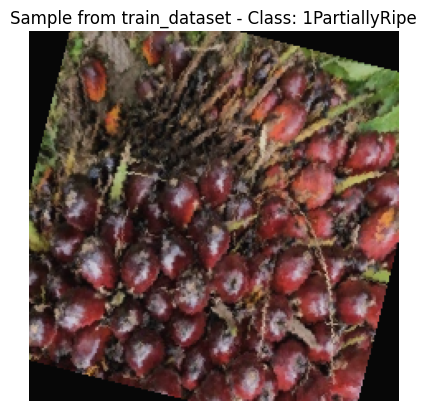

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import random
import numpy as np

# Unnormalize function for visualization
def imshow(img_tensor):
    img = img_tensor.numpy().transpose((1, 2, 0))  # C x H x W → H x W x C
    img = img * 0.5 + 0.5  # unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Pick a random sample
sample_idx = random.randint(0, len(train_dataset) - 1)
image, label = train_dataset[sample_idx]

# Get class name (if available)
class_name = [k for k, v in train_dataset.class_to_idx.items() if v == label.item()][0]

print(f"Class label: {label.item()} ({class_name})")
imshow(image)
plt.title(f"Sample from train_dataset - Class: {class_name}")
plt.show()

In [10]:
# teacher - student models
import torch
import torch.nn as nn
import torchvision.models as models

teacher_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1) # resnet50 as teacher
teacher_model.fc = nn.Linear(teacher_model.fc.in_features, 5)

student_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # mobilenetv2 as student
student_model.classifier[1] = nn.Linear(student_model.last_channel, 5)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
teacher_model.to(device)
student_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.4MB/s]
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 48.2MB/s]


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
num_params_student = sum(p.numel() for p in student_model.parameters() if p.requires_grad)
num_params_teacher = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)
print(f"Teacher model parameters: {num_params_teacher / 1e6:.2f}M")
print(f"Student model parameters: {num_params_student / 1e6:.2f}M")

Teacher model parameters: 23.52M
Student model parameters: 2.23M


In [12]:
# kd loss
def kd_loss_fn(outputs_student, outputs_teacher, labels, T=4, alpha=0.5):
    """
    Knowledge Distillation Loss using Cross Entropy + MSE
    
    Args:
        outputs_student: Student model logits
        outputs_teacher: Teacher model logits  
        labels: Ground truth labels
        alpha: Weight for MSE loss vs CE loss (0.5 means equal weighting)
    
    Returns:
        Combined loss: alpha * mse_loss + (1 - alpha) * ce_loss
    """
    # Cross entropy loss between student predictions and true labels
    ce_loss = nn.CrossEntropyLoss()(outputs_student, labels)
    
    # MSE loss between student and teacher logits
    mse_loss = nn.MSELoss()(outputs_student, outputs_teacher)
    
    # Combined loss
    total_loss = alpha * mse_loss + (1.0 - alpha) * ce_loss
    
    return total_loss

# attention transfer
def attention_transfer_loss(fs, ft):
    return sum([torch.norm(fs[i] - ft[i], p=2) for i in range(len(fs))])

# intermediate feature matching
def feature_loss(student_features, teacher_features):
    loss = 0
    for s, t in zip(student_features, teacher_features):
        loss += nn.MSELoss()(s, t)
    return loss

In [13]:
teacher_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Epoch 1/100, Train Loss: 0.7657, Val Loss: 0.7064, Val Acc: 65.06%
Epoch 2/100, Train Loss: 0.7183, Val Loss: 0.6695, Val Acc: 72.44%
Epoch 3/100, Train Loss: 0.7063, Val Loss: 0.6650, Val Acc: 75.71%
Epoch 4/100, Train Loss: 0.6944, Val Loss: 0.6647, Val Acc: 72.59%
Epoch 5/100, Train Loss: 0.6853, Val Loss: 0.6599, Val Acc: 74.01%
Epoch 6/100, Train Loss: 0.6753, Val Loss: 0.6642, Val Acc: 74.86%
Epoch 7/100, Train Loss: 0.6722, Val Loss: 0.6709, Val Acc: 70.88%
Epoch 8/100, Train Loss: 0.6669, Val Loss: 0.6505, Val Acc: 74.57%
Epoch 9/100, Train Loss: 0.6591, Val Loss: 0.6356, Val Acc: 79.40%
Epoch 10/100, Train Loss: 0.6541, Val Loss: 0.6360, Val Acc: 79.69%
Epoch 11/100, Train Loss: 0.6497, Val Loss: 0.6314, Val Acc: 81.53%
Epoch 12/100, Train Loss: 0.6440, Val Loss: 0.6426, Val Acc: 81.25%
Epoch 13/100, Train Loss: 0.6400, Val Loss: 0.6388, Val Acc: 76.70%
Epoch 14/100, Train Loss: 0.6361, Val Loss: 0.6311, Val Acc: 81.53%
Epoch 15/100, Train Loss: 0.6298, Val Loss: 0.6314, Val A

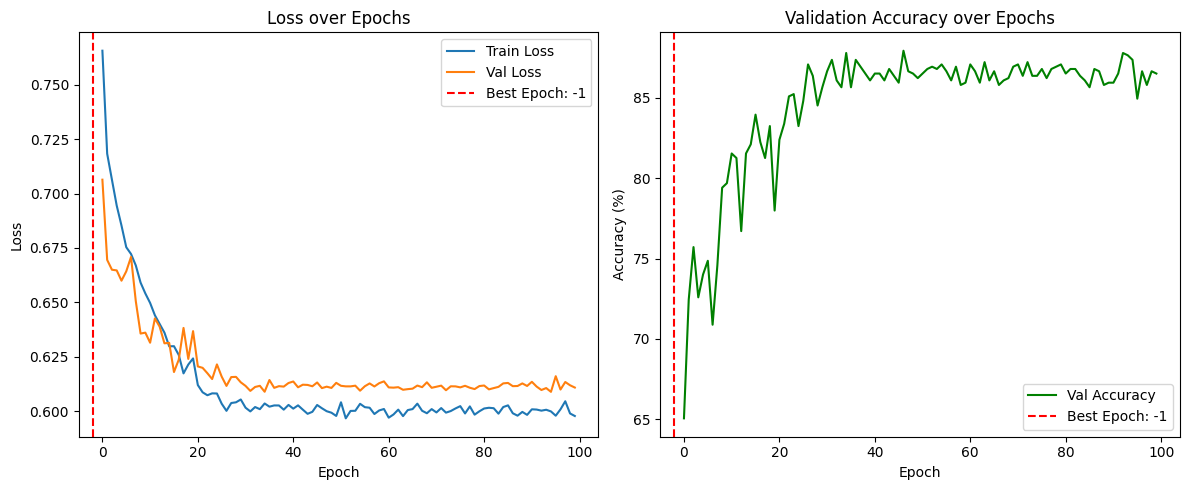

In [14]:
import torch
import matplotlib.pyplot as plt
from PIL import Image

# training setup
optimizer = torch.optim.Adam(student_model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min', 
    factor=0.1, 
    patience=3
)
epochs = 100

best_val_loss = float('inf')
best_epoch = -1
patience = 5
no_improve = 0

# For plotting
train_losses = []
val_losses = []
val_accuracies = []

for epoch in range(epochs):
    student_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        with torch.no_grad():
            teacher_outputs = teacher_model(images)
            
        student_outputs = student_model(images)
        loss = kd_loss_fn(student_outputs, teacher_outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    # Validation phase
    student_model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            teacher_outputs = teacher_model(images)
            student_outputs = student_model(images)
            
            val_loss += kd_loss_fn(student_outputs, teacher_outputs, labels).item()
            _, predicted = student_outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    train_loss = running_loss / len(train_loader)
    val_loss /= len(val_loader)
    val_acc = 100. * correct / total
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")
    
    scheduler.step(val_loss)

    # Early stopping
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss
    #     best_epoch = epoch + 1  # human-readable index
    #     no_improve = 0
    #     torch.save(student_model.state_dict(), 'best_student.pth')
    # else:
    #     no_improve += 1
    #     if no_improve >= patience:
    #         print("Early stopping!")
    #         break

# Plotting
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.axvline(best_epoch - 1, color='r', linestyle='--', label=f'Best Epoch: {best_epoch}')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, label='Val Accuracy', color='g')
plt.axvline(best_epoch - 1, color='r', linestyle='--', label=f'Best Epoch: {best_epoch}')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0     0.8740    0.9652    0.9174       115
           1     0.8930    0.7840    0.8350       213
           2     0.8175    0.9556    0.8811       225
           3     0.9474    0.7059    0.8090       102
           4     0.9538    0.9841    0.9688        63

    accuracy                         0.8733       718
   macro avg     0.8972    0.8790    0.8822       718
weighted avg     0.8794    0.8733    0.8707       718



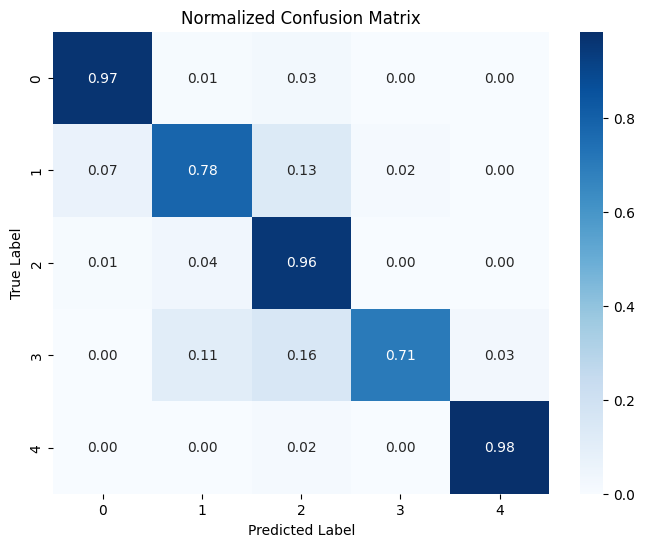

                precision    recall  f1-score   support

     0Immature       0.87      0.97      0.92       115
1PartiallyRipe       0.89      0.78      0.84       213
    2FullyRipe       0.82      0.96      0.88       225
     3OverRipe       0.95      0.71      0.81       102
      4Decayed       0.95      0.98      0.97        63

      accuracy                           0.87       718
     macro avg       0.90      0.88      0.88       718
  weighted avg       0.88      0.87      0.87       718



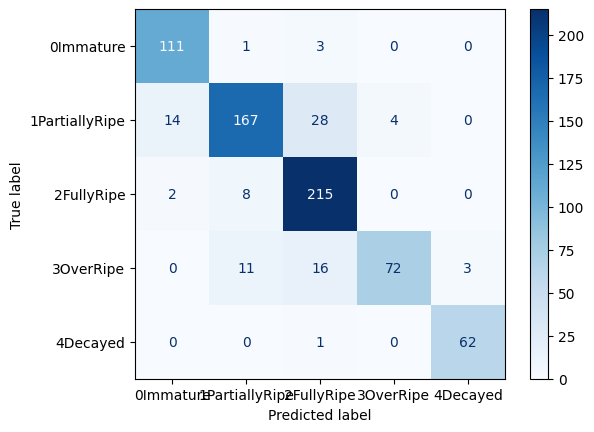

In [15]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Evaluation on test set
student_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = student_model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.cpu().numpy())

# Classification report
print("Classification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", cbar=True)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

target_names = ['0Immature', '1PartiallyRipe', '2FullyRipe', '3OverRipe', '4Decayed']
print(classification_report(all_labels, all_preds, target_names=target_names))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names).plot(cmap="Blues")